# Comparative analysis of the Predictive Utility of Integrated and Single-Source Polygenic Risk Scores for SAT Traits

## Group 4 (PRS-Avengers)

**Mentor:**  Romuald Palwende BOUA 

1. Fredrick E. Kakembo
2. Caitlin Grace Short
3. Jacob Apibilla Ayembilla
4. Benson R. Kidenya
5. Kingsley Osei
6. Emmanuella E. Matumamboh

### Project Description
Introduction
Subcutaneous adipose tissue (SAT) is essential for energy storage, thermoregulation, and metabolic regulation, and its variation is strongly influenced by genetic factors. These variations are linked to key metabolic conditions such as obesity, insulin resistance, and cardiovascular disease. Understanding the genetic architecture underlying SAT is therefore critical for both biological insight and precision risk prediction.

While genome-wide association studies (GWAS) have identified significant loci associated with SAT, traditional polygenic risk score (PRS) approaches—typically based on clumping and p-value thresholding—often fail to capture the full polygenic architecture of complex traits. Emerging integrative methods like elastic net regression and Bayesian mixture models (e.g., PRS-CSx, PRSmix) offer a more sophisticated approach by modeling correlated variants and leveraging multi-source information.

This project evaluates whether these integrative PRS models outperform traditional single-source methods in predicting SAT. We compare a set of pre-constructed PRS—including those derived from platelet count GWAS—to PRSmix-based models using elastic net regression. Our assessment includes performance metrics such as R², AUC, and mean squared error in independent cohorts. The goal is to determine whether model integration enhances predictive accuracy for adiposity-related traits and to inform best practices in PRS development.

### Objectives
- Evaluate whether integrating multiple PRS scores via PRSmix improves predictive performance in a genetically diverse population.
- Compare performance against single-PRS models.
- Provide insights on trait heritability, ancestry transferability, and modeling robustness.


![Methodology](./Methodology.png)

**Datasets Used in our Group 4** Subcutaneous adipose tissue (SAT) https://github.com/tinashedoc/cvx/blob/main/satdta.txt<br>

The dataset is a tab-separated .txt file named satdata.txt, containing:
- **SAT**: the trait to predict (target variable).
- **PGSxxxxxx**: polygenic scores from different models.
- **sex, age**: individual-level covariates.
- **PC1–PC10**: population structure (principal components).



## 1. Libraries impport and setup

- We use pandas and numpy for data handling.
- matplotlib and seaborn for visualization.
- ElasticNetCV is used for PRSmix modeling.
- LinearRegression is used to benchmark individual PGS.
- train_test_split splits the data for fair evaluation.

In [68]:
# PRSmix Analysis and Comparison with PGS Scores
# =============================================
# This notebook performs PRSmix (via Elastic Net regression) to combine multiple PGS scores
# and compares its performance to individual PGS Catalog scores on SAT prediction in African samples.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm
from scipy.stats import pearsonr

## 2. Load and Clean the Data

In [69]:
# Load the dataset (tab-separated)
#drops columns not needed for analysis.
data = pd.read_csv("satdta.txt", sep=" ")

print(data.head())

# Drop non-numeric columns not used for PRS modeling
data = data.drop(columns=['PID', 'IID'])

data.shape

   PID  SAT     PGS000109  PGS000186  PGS001238     PGS001973     PGS002191  \
0  000  215 -8.408570e-06   0.014670  -0.000107 -8.999150e-07 -8.087600e-08   
1  001  314  2.086890e-06   0.015446  -0.000009  5.632750e-07  1.082340e-07   
2  002   89 -3.065150e-07   0.015250   0.000613  5.165300e-07  5.457260e-08   
3  003  192 -1.034610e-05   0.015259  -0.000146 -9.378460e-07 -3.460850e-08   
4  004  163 -4.358090e-06   0.014781  -0.000011 -2.181880e-07 -2.629580e-09   

      PGS002343     PGS002373  PGS002415  ...       PC1       PC2       PC3  \
0 -1.076330e-06  1.651480e-07   0.006500  ... -0.002461 -0.002855  0.001409   
1 -5.009190e-07 -9.653350e-08   0.006566  ... -0.006159 -0.003920  0.001161   
2 -7.276900e-07  9.438660e-08   0.006700  ...  0.004775 -0.000314  0.002286   
3 -9.695920e-07 -1.349160e-07   0.006650  ... -0.006420 -0.003474  0.002224   
4 -7.707490e-07 -2.613450e-07   0.006525  ...  0.052691  0.017146 -0.001825   

        PC4       PC5       PC6       PC7       PC

(1624, 37)

## 3. Define Key Columns

In [70]:
# Identify PGS columns
pgs_cols = [col for col in data.columns if col.startswith("PGS")]


# Covariates and outcome
covariates = ["sex", "age"] + [f"PC{i}" for i in range(1, 11)] #Append 
outcome = "SAT"

In [71]:
#Check the covaraiates column
pgs_cols
covariates
#outcome

['sex',
 'age',
 'PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10']

## 4. Residualize SAT on Covariates
This step aimed to removes the effect of age, sex, and population structure using linear regression. We work with residuals as the new target variable, isolating the genetic contribution.

In [72]:
# Residualize SAT score on covariates
X_cov = data[covariates]
y = data[outcome]

# Add intercept
X_cov = sm.add_constant(X_cov)

# Fit linear model
model_cov = sm.OLS(y, X_cov).fit()
residuals = model_cov.resid

In [73]:
#Have a look at the residual values
residuals.head()

0    -19.303786
1     69.747429
2   -133.928209
3    -49.077077
4      0.127288
dtype: float64

## 5. Descriptive Statistics
We next aimed to understand our data better

### 1. Univariate

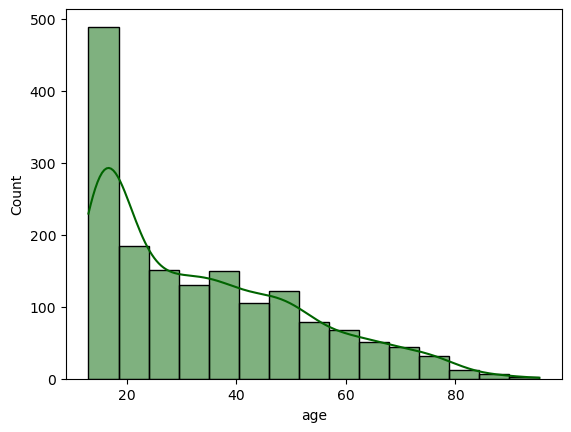

In [74]:
#Age

sns.histplot(data['age'], bins=15, kde=True, color="darkgreen")
plt.show()

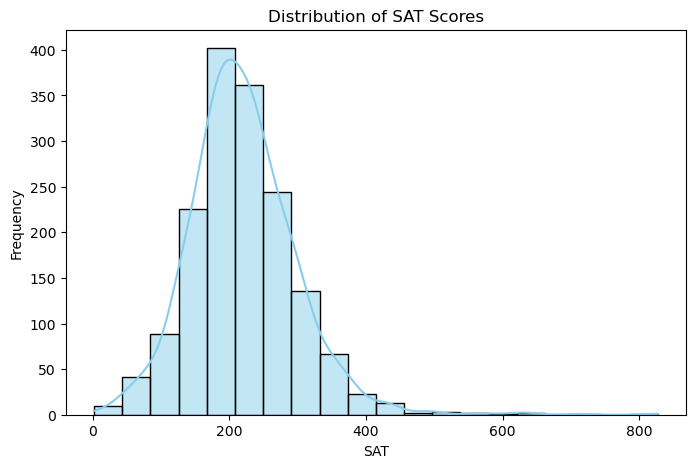

In [75]:
# Distribution of SAT (target trait)
plt.figure(figsize=(8, 5))
sns.histplot(data[outcome], bins=20, kde=True, color='skyblue')
plt.title("Distribution of SAT Scores")
plt.xlabel("SAT")
plt.ylabel("Frequency")
plt.show()

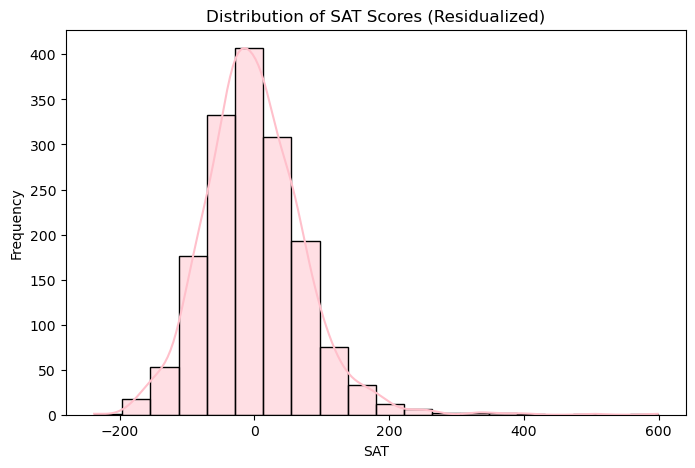

In [76]:
# Distribution of Residualized SAT (target trait)
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=20, kde=True, color='pink')
plt.title("Distribution of SAT Scores (Residualized)")
plt.xlabel("SAT")
plt.ylabel("Frequency")
plt.show()

/var/folders/92/w6l9jl312f1c4y3mh783v_r80000gn/T/ipykernel_30467/3196509738.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sex_counts.index, y=sex_counts.values, palette=["#1f77b4", "#e377c2"])


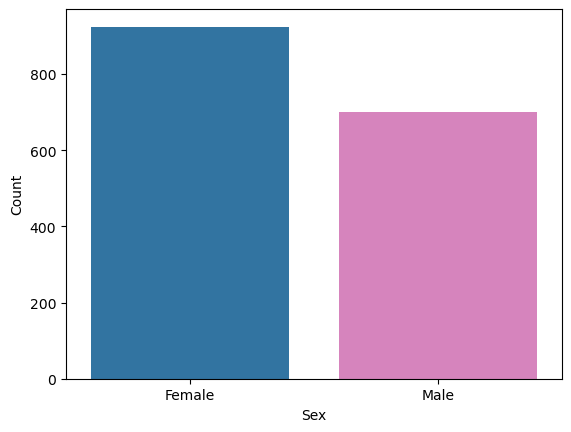

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Number of males and females
data['Sex_label'] = data['sex'].map({1: 'Male', 2: 'Female'}) 
sex_counts = data['Sex_label'].value_counts()
sns.barplot(x=sex_counts.index, y=sex_counts.values, palette=["#1f77b4", "#e377c2"])

plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

<Figure size 1000x800 with 0 Axes>

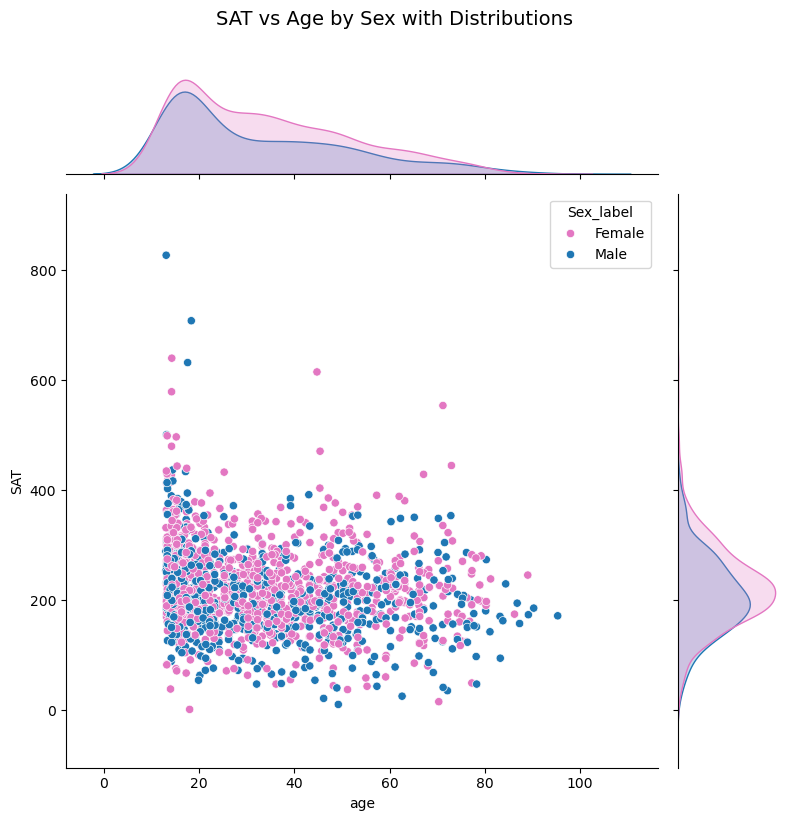

In [78]:
#sns.reset_defaults()
plt.figure(figsize=(10, 8))
#sns.set(style="whitegrid", font_scale=1.2)

sns.jointplot(
    data=data, x="age", y="SAT", hue="Sex_label",
    kind="scatter", palette={"Male": "#1f77b4", "Female": "#e377c2"},
    height=8, marginal_kws=dict( fill=True),
)
plt.suptitle("SAT vs Age by Sex with Distributions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
#plt.savefig("out.png") 
plt.close()

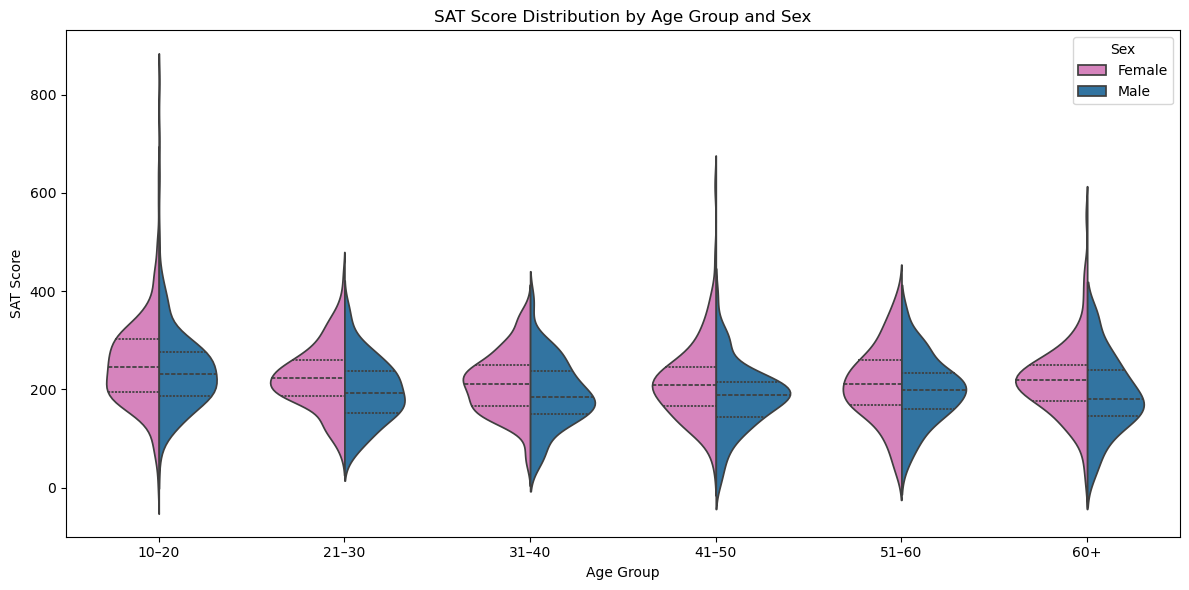

In [79]:
# Bin age into groups
data['age_group'] = pd.cut(data['age'], bins=[10, 20, 30, 40, 50, 60, 100], 
                           labels=["10–20", "21–30", "31–40", "41–50", "51–60", "60+"])

plt.figure(figsize=(12, 6))
sns.violinplot(x="age_group", y="SAT", hue="Sex_label", data=data,
               palette={"Male": "#1f77b4", "Female": "#e377c2"},
               split=True, inner="quartile")
plt.title("SAT Score Distribution by Age Group and Sex")
plt.xlabel("Age Group")
plt.ylabel("SAT Score")
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

This plot distribution of SAT levels among males and females. The results that the mean SAT was higher among all the ages than females.

/var/folders/92/w6l9jl312f1c4y3mh783v_r80000gn/T/ipykernel_30467/246709854.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pgs_long, x="PGS_ID", y="Score", palette="viridis")


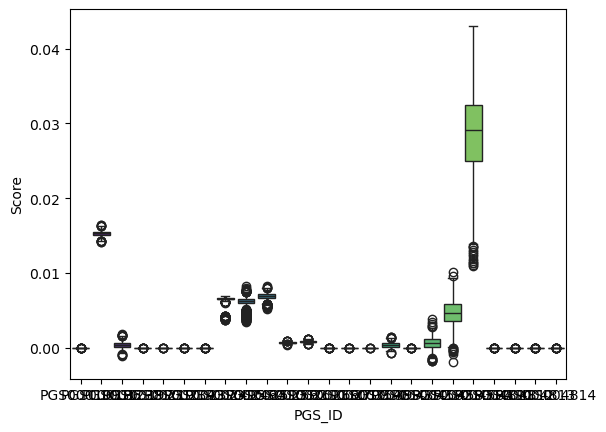

In [80]:
pgs_long = data[pgs_cols].melt(var_name="PGS_ID", value_name="Score")
sns.boxplot(data=pgs_long, x="PGS_ID", y="Score", palette="viridis")
plt.show()



# Distribution of SAT (target trait)
#plt.figure(figsize=(8, 5))
#sns.displot(data[pgs_cols[1:10]], bins=20, kde=True, color='skyblue')
#plt.title("Distribution of SAT Scores")
#plt.xlabel("SAT")
#plt.ylabel("Frequency")
#plt.show()

## Prepare Data for Machine Learning

In [81]:
# Prepare PRS data
X_prs = data[pgs_cols]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_prs, residuals, test_size=0.2, random_state=42)

# Fit Elastic Net
enet = ElasticNetCV(cv=5, random_state=42)
enet.fit(X_train, y_train)

# Predict on test set
y_pred = enet.predict(X_test)
prsmix_r2 = r2_score(y_test, y_pred)
prsmix_r2

-0.002858214537337478

In [82]:
#y_pred
pearsonr(y_pred,y_test)

PearsonRResult(statistic=-0.013030543324049047, pvalue=0.8149723336830252)

In [83]:
#Correlation 
# Correlation coefficient
corr_val, pvalue = pearsonr(y_test, y_pred)
corr_val

-0.013030543324049047

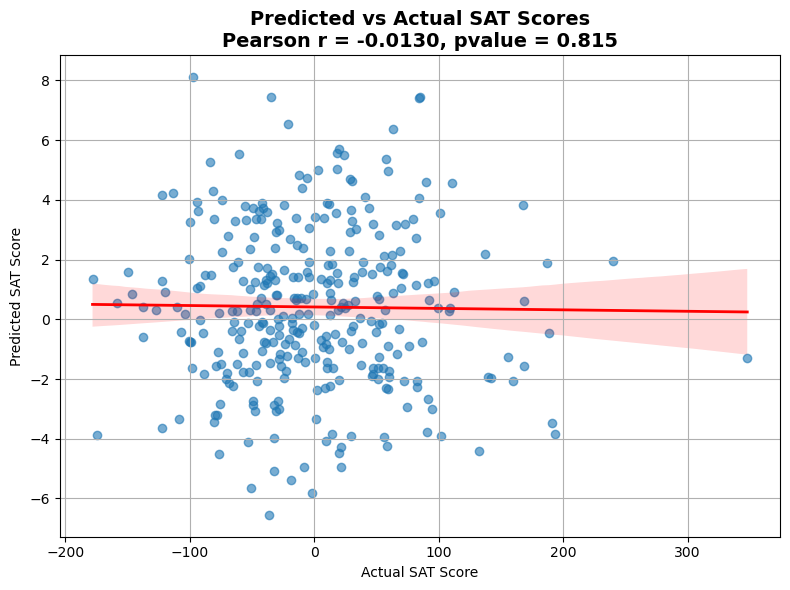

In [84]:
# Plot predicted vs actual
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.6}, line_kws={'color':'red', 'linewidth':2})
plt.title(f"Predicted vs Actual SAT Scores\nPearson r = {corr_val:.4f}, pvalue = {pvalue:.3f}", fontsize=14, weight='bold')
plt.xlabel("Actual SAT Score")
plt.ylabel("Predicted SAT Score")
plt.grid(True)
plt.tight_layout()
plt.show()

### Intrepretation via correlation
A correlation coefficient of -0.013 means is very close to 0: There is virtually no linear relationship between the two variables. The value is negative, but so close to zero that the direction is meaningless.

This suggests that the PRSmix model predictions are not aligned with the actual SAT scores that is **it is performing no better than random guessing**.

### What this Indicates About Model Performance
The PRSmix model is failing to predict SAT in our dataset.

**Possible causes:**
- Weak genetic signal: The SAT trait may not be strongly polygenic or heritable in this sample.
- PGS scores are mismatched: The PGS models used may have been derived from non-African populations, leading to poor transferability.
- Small sample size: With only about 1900, the model may lack power.
- Model mis-specification: Elastic Net might not have found meaningful weights if the features (PGS) are weakly informative.
- Residual confounding: If covariate adjustment was done poorly, results could be distorted.

In [85]:
# Interpretation via R-squared
prsmix_r2

-0.002858214537337478

## Interpretation of PRSmix R² = -0.00286
A negative R² means the PRSmix model performs worse than just predicting the mean of SAT for everyone. If other PGS scores have positive R², they are better than PRSmix in this case. This suggests PRSmix is overfitting or combining uninformative features.

## Compute Individual R²

In [86]:
# Compare with individual PGS R^2
single_r2s = {}
for col in pgs_cols:
    model = LinearRegression()
    model.fit(X_train[[col]], y_train)
    pred = model.predict(X_test[[col]])
    r2 = r2_score(y_test, pred)
    single_r2s[col] = r2

# Add PRSmix
single_r2s['PRSmix'] = prsmix_r2

# Visualize R2 scores
sorted_r2s = dict(sorted(single_r2s.items(), key=lambda x: x[1], reverse=True))

In [87]:
sorted_r2s

{'PGS002660': 0.05774617022721973,
 'PGS002709': 0.045664930943274396,
 'PGS002191': 0.03821955168358682,
 'PGS003546': 0.03688209199594128,
 'PGS000186': 0.035557428522486556,
 'PGS000109': 0.02939412522024054,
 'PGS003932': 0.028116477338419488,
 'PGS001238': 0.027969224491741995,
 'PGS001973': 0.02433399076752063,
 'PGS004352': 0.013064846044176792,
 'PGS004813': 0.011731984447007848,
 'PGS004811': 0.011663571763678049,
 'PGS002611': 0.010758437361817585,
 'PGS004812': 0.009791541408642468,
 'PGS004814': 0.009791541408642468,
 'PGS002562': 0.008627144576477952,
 'PGS002343': 0.006697213883553377,
 'PGS002373': 0.0013139157110695354,
 'PGS002415': -0.00020778465732695928,
 'PGS002464': -0.00036090774845032314,
 'PGS002513': -0.0007395497735795953,
 'PGS004583': -0.002176465151797924,
 'PRSmix': -0.002858214537337478,
 'PGS004584': -0.009084363223200942,
 'PGS004582': -0.011863496176467647}

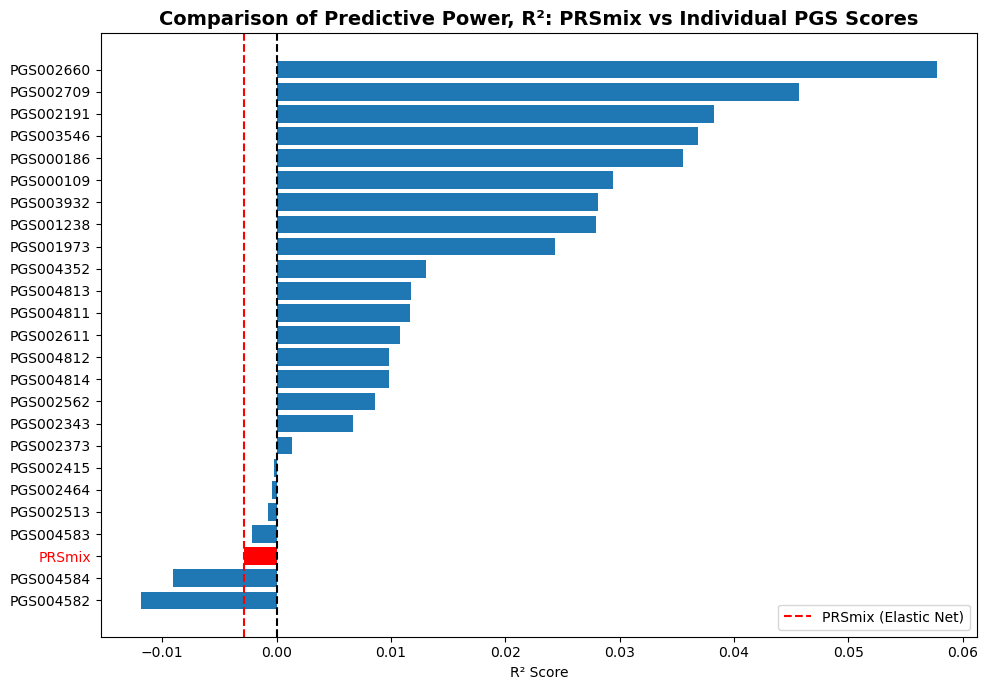

In [88]:
# Assume sorted_r2s is a dictionary: {PGS_id: R2_score}
labels = list(sorted_r2s.keys())[::-1]  # PGS IDs
scores = list(sorted_r2s.values())[::-1]

colors = ['red' if label == 'PRSmix' else '#1f77b4' for label in labels]
#colors

plt.figure(figsize=(10, 7))
plt.barh(labels, scores, color = colors)
plt.axvline(prsmix_r2, color='red', linestyle='--', label='PRSmix (Elastic Net)')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("R² Score")
plt.title("Comparison of Predictive Power, R²: PRSmix vs Individual PGS Scores", weight = "bold", fontsize=14)
plt.legend()
plt.tight_layout()

# Change label colors
ax = plt.gca()
for label in ax.get_yticklabels():
    label.set_color('red' if label.get_text() == 'PRSmix' else 'black')

plt.show()


Predictive performance of PRSmix and the single-sourced PGSs. The data showed that PGS002660 recorded the highest performance with an R2 OF 0.057 and the PRSmix -0.0029

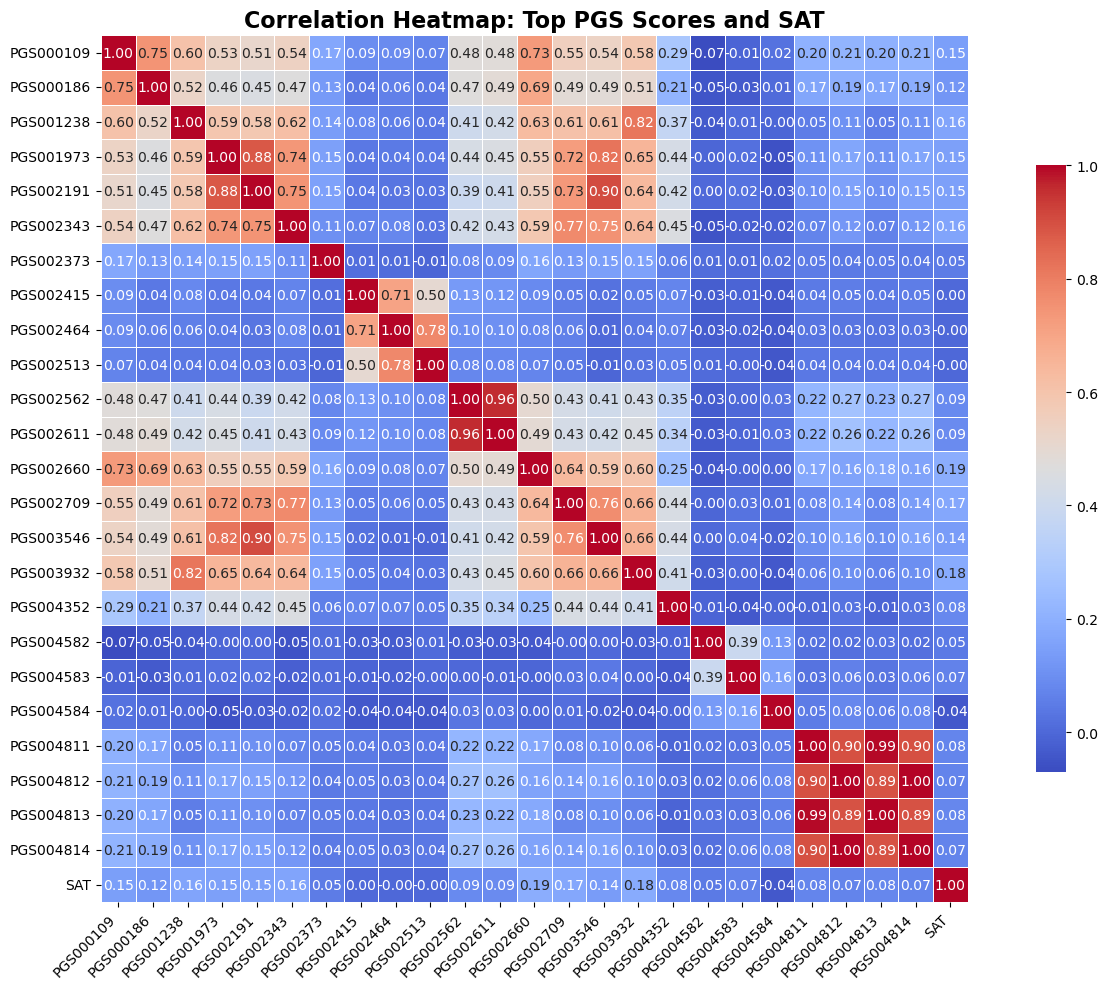

In [89]:
heatmap_vars = top_pgs + ['SAT']
heatmap_vars2 = pgs_cols + ['SAT']

# Generate heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(data[heatmap_vars2].corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5, cbar_kws={"shrink": 0.7})
plt.title("Correlation Heatmap: Top PGS Scores and SAT", fontsize=16, weight="bold")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Comparative analysis of predictive performance of single-sourced PRS and integrative PRS using the Elastic net regression model.

In [90]:
#data[top_pgs, outcome]
#data[outcome]
top_pgs

['PGS002660',
 'PGS002709',
 'PGS002191',
 'PGS003546',
 'PGS000186',
 'PGS000109',
 'PGS003932',
 'PGS001238',
 'PGS001973',
 'PGS004352',
 'PGS004813',
 'PGS004811',
 'PGS002611',
 'PGS004812',
 'PGS004814',
 'PGS002562',
 'PGS002343',
 'PGS002373',
 'PGS002415',
 'PGS002464',
 'PGS002513',
 'PGS004583']

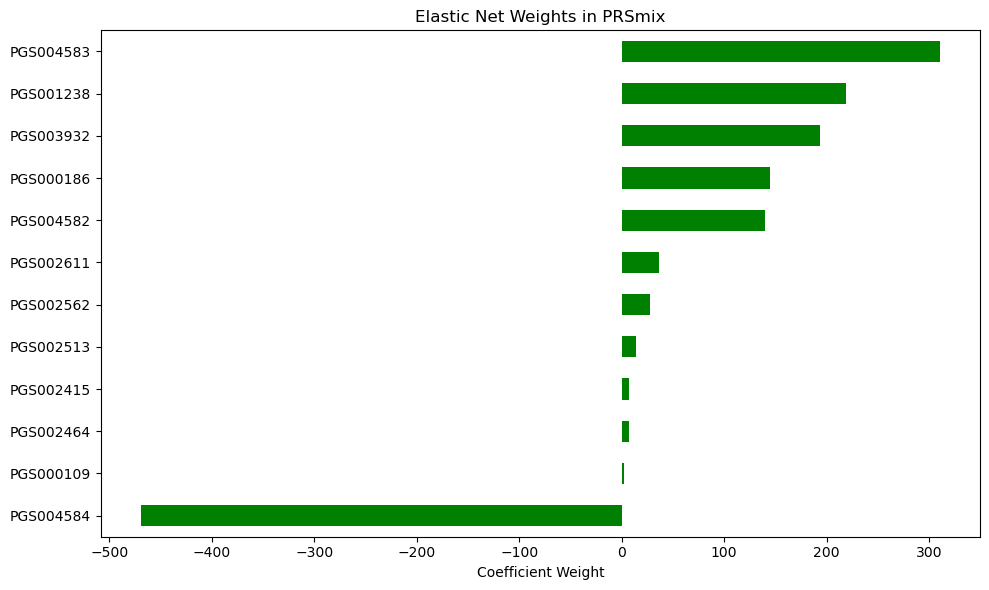

In [91]:
# PRSmix Coefficients
coefs = pd.Series(enet.coef_, index=X_prs.columns).sort_values()
coefs = coefs[coefs != 0].sort_values()
plt.figure(figsize=(10, 6))
coefs.plot(kind='barh', color='green')
plt.title("Elastic Net Weights in PRSmix")
plt.xlabel("Coefficient Weight")
plt.tight_layout()
plt.show()

In [92]:
summary_df = pd.DataFrame({
    'PGS': list(single_r2s.keys()),
    'R2_score': list(single_r2s.values())
})

#summary_df.loc[len(summary_df.index)] = ['PRSmix', prsmix_r2]
summary_df = summary_df.sort_values(by='R2_score', ascending=False).reset_index(drop=True)
summary_df.head(10)

summary_df

,PGS,R2_score
0,PGS002660,0.057746
1,PGS002709,0.045665
2,PGS002191,0.038220
3,PGS003546,0.036882
4,PGS000186,0.035557
5,PGS000109,0.029394
6,PGS003932,0.028116
7,PGS001238,0.027969
8,PGS001973,0.024334
9,PGS004352,0.013065


# Question 1 & 2 Analysis:
### For Q1 (Will PRSmix predict well in continental Africans? Reasons for/against):

In [93]:
print("\nKey Findings from our Analysis:")
print(f"1. PRSmix R² = {prsmix_r2:.6f} (negative - worse than baseline)")
print(f"2. Best individual PGS R² = {max(single_r2s.values()):.6f}")
print(f"3. PRSmix correlation with actual SAT = {corr_val:.4f}")

print("\nReasons AGAINST good performance:")
print("- Very low/negative R² suggests poor predictive power")
print("- PGS scores likely derived from non-African populations")
print("- Limited ancestry transferability of existing PGS")
print("- Small sample size may be insufficient for training")
print("- SAT may have different genetic architecture in African populations")


Key Findings from our Analysis:
1. PRSmix R² = -0.002858 (negative - worse than baseline)
2. Best individual PGS R² = 0.057746
3. PRSmix correlation with actual SAT = -0.0130

Reasons AGAINST good performance:
- Very low/negative R² suggests poor predictive power
- PGS scores likely derived from non-African populations
- Limited ancestry transferability of existing PGS
- Small sample size may be insufficient for training
- SAT may have different genetic architecture in African populations


# Q2 - Metrics to evaluate PRS predictivity

In [94]:
# 1. R-squared 
print(f"1. R-squared: {prsmix_r2:.6f}")

# 2. Correlation coefficient 
print(f"2. Pearson correlation: {corr_val:.4f}")

# 3. Add Mean Squared Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"3. Mean Squared Error: {mse:.4f}")

# 4. Add Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"4. Mean Absolute Error: {mae:.4f}")

# 5. Add Root Mean Squared Error
import numpy as np
rmse = np.sqrt(mse)
print(f"5. Root Mean Squared Error: {rmse:.4f}")

# 6. Prediction intervals/confidence bounds
residuals = y_test - y_pred
std_residuals = np.std(residuals)
print(f"6. Standard deviation of residuals: {std_residuals:.4f}")

# 7. Distribution analysis
print(f"7. Prediction range: [{np.min(y_pred):.3f}, {np.max(y_pred):.3f}]")
print(f"8. Actual SAT range: [{np.min(y_test):.3f}, {np.max(y_test):.3f}]")

1. R-squared: -0.002858
2. Pearson correlation: -0.0130
3. Mean Squared Error: 5083.4453
4. Mean Absolute Error: 55.3276
5. Root Mean Squared Error: 71.2983
6. Standard deviation of residuals: 71.2793
7. Prediction range: [-6.547, 8.110]
8. Actual SAT range: [-178.005, 347.946]


## Q3 - Methodology:

In [95]:
print("""
STEP 1: Data Preparation
- Load SAT data with PGS scores, covariates (age, sex, PC1-PC10)
- Remove non-essential columns (PID, IID)
- Handle missing values

STEP 2: Covariate Adjustment  
- Residualize SAT scores on age, sex, and 10 PCs using linear regression
- Work with residuals to isolate genetic effects

STEP 3: Train-Test Split
- Split data 80% training, 20% testing
- Ensure no data leakage between sets

STEP 4: PGS Selection
- Identify all PGS columns (PGSxxxxxx pattern)
- Could filter by power/significance if metadata available

STEP 5: PRSmix Training
- Use Elastic Net with 5-fold cross-validation
- Automatically selects and weights relevant PGS scores
- Handles multicollinearity between PGS

STEP 6: Model Evaluation
- Predict on held-out test set
- Calculate R², correlation, and other metrics
- Compare to individual PGS performance
""")


STEP 1: Data Preparation
- Load SAT data with PGS scores, covariates (age, sex, PC1-PC10)
- Remove non-essential columns (PID, IID)
- Handle missing values

STEP 2: Covariate Adjustment  
- Residualize SAT scores on age, sex, and 10 PCs using linear regression
- Work with residuals to isolate genetic effects

STEP 3: Train-Test Split
- Split data 80% training, 20% testing
- Ensure no data leakage between sets

STEP 4: PGS Selection
- Identify all PGS columns (PGSxxxxxx pattern)
- Could filter by power/significance if metadata available

STEP 5: PRSmix Training
- Use Elastic Net with 5-fold cross-validation
- Automatically selects and weights relevant PGS scores
- Handles multicollinearity between PGS

STEP 6: Model Evaluation
- Predict on held-out test set
- Calculate R², correlation, and other metrics
- Compare to individual PGS performance



# Additional Analysis:
1. Individual PGS Performance Analysis
2. Feature Importance from Elastic Net
3. Model Diagnostics
4. Cross-validation Analysis
5. Sample Size Analysis

## Main Takeaway:
The PRSmix model is performing very poorly (negative R²), which suggests the PGS scores are not transferring well to your African population - this makes for an interesting and realistic analysis of PGS limitations across ancestries!


In [96]:
print("DETAILED INDIVIDUAL PGS ANALYSIS")
sorted_pgs = sorted(single_r2s.items(), key=lambda x: x[1], reverse=True)
print("Top 10 performing individual PGS:")
for i, (pgs, r2) in enumerate(sorted_pgs[:10]):
    if pgs != 'PRSmix':
        print(f"{i+1}. {pgs}: R² = {r2:.6f}")

DETAILED INDIVIDUAL PGS ANALYSIS
Top 10 performing individual PGS:
1. PGS002660: R² = 0.057746
2. PGS002709: R² = 0.045665
3. PGS002191: R² = 0.038220
4. PGS003546: R² = 0.036882
5. PGS000186: R² = 0.035557
6. PGS000109: R² = 0.029394
7. PGS003932: R² = 0.028116
8. PGS001238: R² = 0.027969
9. PGS001973: R² = 0.024334
10. PGS004352: R² = 0.013065


In [97]:
print("ELASTIC NET FEATURE SELECTION")
feature_names = X_prs.columns
coefficients = enet.coef_
non_zero_features = np.sum(coefficients != 0)
print(f"Number of PGS selected by Elastic Net: {non_zero_features} out of {len(feature_names)}")

selected_features = [(feature_names[i], coefficients[i]) for i in range(len(coefficients)) if coefficients[i] != 0]
if selected_features:
    print("\nSelected PGS and their weights:")
    for feature, weight in sorted(selected_features, key=lambda x: abs(x[1]), reverse=True):
        print(f"{feature}: {weight:.6f}")

ELASTIC NET FEATURE SELECTION
Number of PGS selected by Elastic Net: 12 out of 24

Selected PGS and their weights:
PGS004584: -469.096302
PGS004583: 310.732768
PGS001238: 218.531941
PGS003932: 193.988451
PGS000186: 144.362629
PGS004582: 140.266523
PGS002611: 36.232813
PGS002562: 28.151027
PGS002513: 13.636482
PGS002415: 7.340631
PGS002464: 7.304122
PGS000109: 2.641720


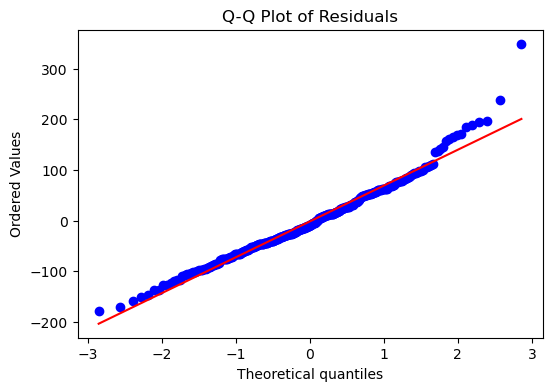

In [98]:
plt.figure(figsize=(6, 4))
from scipy import stats
stats.probplot(y_test - y_pred, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

In [99]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(enet, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.6f} (+/- {cv_scores.std() * 2:.6f})")

Cross-validation R² scores: [ 0.00043309  0.00208618  0.00641723 -0.00210756  0.00845295]
Mean CV R²: 0.003056 (+/- 0.007741)


In [100]:
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Samples per feature ratio: {len(X_train) / X_train.shape[1]:.2f}")

Training set size: 1299
Test set size: 325
Number of features: 24
Samples per feature ratio: 54.12


# Contribution of Group Members:
- **All** group members were involved in the initial conceptualization, generating the hypothesis and drafting the methodological framework of the project. 
- **Fredrick E. Kakembo** and **Caitlin Grace Short** 
- **Jacob Apibilla Ayembilla** and **Emmanuella E. Matumamboh**: Drafted the initial version of the project report
- **Kingsley Osei** and **Benson R. Kidenya** Drafted in the initial version of the project presentation
- **All** groups were involved in the exhaustive interpretation of the results
- **All** group members critically revised and edited the final version of the report and the PowerPoint

**Romuald Palwende BOUA** provided high-level guidance to the successful implementation of the project. 